In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Dense, Concatenate, Flatten, BatchNormalization, TextVectorization
from keras.models import Model
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
# Read the CSV file
data = pd.read_csv("R.csv")

In [6]:
labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

input_features = labels[feature_headings]
output_values = labels[[c for c in labels.columns if c not in feature_headings]]



input_train, input_test, output_train, output_test = train_test_split(input_features, output_values, test_size=0.2, random_state=42)
input_train, input_val, output_train, output_val = train_test_split(input_train, output_train, test_size=0.2, random_state=42)


In [7]:
thicknesses = Input(shape=(6,))
materials = Input(shape=(2,),dtype=tf.string)
vocab_size = 300


vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=1,
    name="string_vec"
)

vectorize_layer.adapt(input_train["First Layer"])

vectorized_mat1 = vectorize_layer(materials[:,:1])
vectorized_mat2 = vectorize_layer(materials[:,1:])

v_materials = Concatenate()([vectorized_mat1, vectorized_mat2])

material_embedding = Embedding(input_dim=vocab_size, output_dim=8)(v_materials)
material_embedding = Flatten()(material_embedding)

dense_layer1 = Dense(units=256, activation='PReLU')(thicknesses)

dense_layer2 = Dense(units=128, activation='PReLU')(dense_layer1)

dense_layer3 = Dense(units=64, activation='PReLU')(dense_layer2)

concatenated_features = Concatenate()([dense_layer3, material_embedding])

dense_layer4 = Dense(units=128, activation='PReLU')(concatenated_features)

dense_layer5 = Dense(units=64, activation='PReLU')(dense_layer4)

output_layer = Dense(units=351, activation='sigmoid')(dense_layer5)

model = Model(inputs=[thicknesses,materials], outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics="accuracy")

In [8]:

history=model.fit(
    [
        input_train[["d1","d2","d3","d4","d5","d6"]],
        input_train[["First Layer", "Second Layer"]]
    ],
    output_train,
    validation_data=(
        [
            input_val[["d1","d2","d3","d4","d5","d6"]],
            input_val[["First Layer", "Second Layer"]] 
        ],
        output_val
    ),
    epochs=100
)


Epoch 1/100
600/600 [==============================] - 4s 4ms/step - loss: 0.0430 - accuracy: 0.0188 - val_loss: 0.0164 - val_accuracy: 0.0215
Epoch 2/100
600/600 [==============================] - 2s 4ms/step - loss: 0.0132 - accuracy: 0.0535 - val_loss: 0.0107 - val_accuracy: 0.0733
Epoch 3/100
600/600 [==============================] - 2s 4ms/step - loss: 0.0097 - accuracy: 0.0770 - val_loss: 0.0085 - val_accuracy: 0.0750
Epoch 4/100
600/600 [==============================] - 2s 4ms/step - loss: 0.0075 - accuracy: 0.0609 - val_loss: 0.0064 - val_accuracy: 0.0717
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 0.0057 - accuracy: 0.0502 - val_loss: 0.0052 - val_accuracy: 0.0567
Epoch 6/100
600/600 [==============================] - 2s 4ms/step - loss: 0.0047 - accuracy: 0.0425 - val_loss: 0.0042 - val_accuracy: 0.0775
Epoch 7/100
600/600 [==============================] - 2s 4ms/step - loss: 0.0041 - accuracy: 0.0654 - val_loss: 0.0039 - val_accuracy: 0.0581

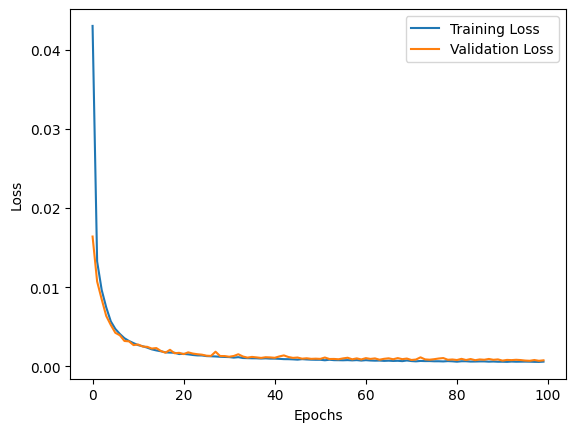

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 52ms/step


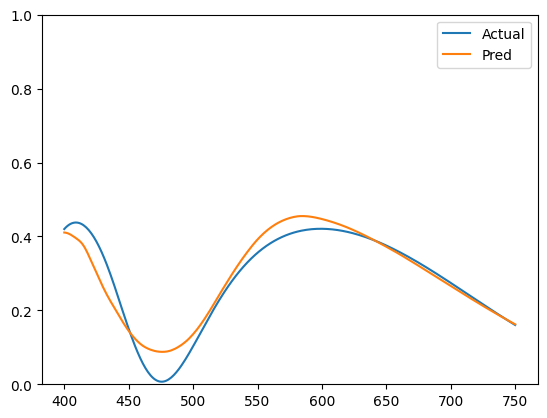

In [50]:
# Select a random index from the test set
index = random.randint(0, len(input_test) - 1)
# index = 2849

# Get the corresponding input and output values
input_sample = input_test.iloc[[index]]
output_sample = output_test.iloc[[index]]

# Make a prediction for the selected sample
prediction = model.predict([input_sample[["d1","d2","d3","d4","d5","d6"]], input_sample[["First Layer", "Second Layer"]]])
output_sample = np.squeeze(output_sample)
prediction = np.squeeze(prediction)
fig,ax = plt.subplots()
x = np.arange(400,751)
ax.plot(x, output_sample, label='Actual')
ax.plot(x, prediction, label='Pred')
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [ ]:
model.save("forward_model")

INFO:tensorflow:Assets written to: forward_model/assets


INFO:tensorflow:Assets written to: forward_model/assets
